In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pickle
import copy

# import our utils
import sys
sys.path.append(os.getcwd() + "\..\preprocess")
import preprocess

%load_ext autoreload
%autoreload 2

use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
    print ("using CUDA")
else:
    device = torch.device('cpu')
    


using CUDA


In [2]:
data_dir = '../data/image_data/'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}


In [3]:
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 2845 images under train
Loaded 494 images under val
Loaded 371 images under test
Classes: 
['flood', 'not_flood']


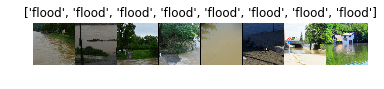

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)


In [5]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        with torch.no_grad():
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]

            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)

            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()

            images_so_far += size
            if images_so_far >= num_images:
                break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [20]:
print (vgg16)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [23]:
# load in vgg16 model
if 'heidi' in os.getcwd():
    vgg16 = models.vgg16()
    vgg16.load_state_dict(torch.load("C:/Users/heidi/.torch/models/vgg16-397923af.pth"))
else:
    vgg16 = models.vgg16(pretrained=True)

# vgg16 = models.inception_v3(pretrained=True)
# vgg16.load_state_dict(torch.load('C:/Users/heidi/.torch/models./resnet18-5c106cde.pth'))
    
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): C

In [7]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data
        with torch.no_grad():
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss_test += loss.data[0]
            acc_test += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
    
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test.item() / dataset_sizes[TEST]
    
#     print (acc_test.cpu() / dataset_sizes[TEST])
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [10]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [37]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 0/47

C:\Users\heidi\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Evaluation completed in 0m 12s
Avg loss (test): 0.0822
Avg acc (test): 0.6658
----------


Ground truth:


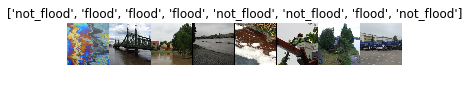

Prediction:


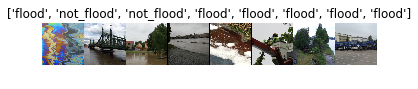

In [38]:
visualize_model(vgg16) 

In [11]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    loss_hist = []
    
    train_batches = len(dataloaders[TRAIN])
#     print (train_batches)
#     return None
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            loss_train += loss.data[0]
            acc_train += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        loss_hist.append(loss_train)

        print()
        # * 2 as we only used half of the dataset
        print (acc_train)
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train.item() * 2 / dataset_sizes[TRAIN]

        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            with torch.no_grad():
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = vgg(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss_val += loss.data[0]

                acc_val += torch.sum(preds == labels.data)

                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()

            avg_loss_val = loss_val / dataset_sizes[VAL]
            avg_acc_val = acc_val.item() / dataset_sizes[VAL]

            print()
            print("Epoch {} result: ".format(epoch))
            print("Avg loss (train): {:.4f}".format(avg_loss))
            print("Avg acc (train): {:.4f}".format(avg_acc))
            print("Avg loss (val): {:.4f}".format(avg_loss_val))
            print("Avg acc (val): {:.4f}".format(avg_acc_val))
            print('-' * 10)
            print()

            if avg_acc_val > best_acc:
                best_acc = avg_acc_val
                best_model_wts = copy.deepcopy(vgg.state_dict())

        elapsed_time = time.time() - since
        print()
        
        print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
        print("Best acc: {:.4f}".format(best_acc))
        
        vgg.load_state_dict(best_model_wts)
        return vgg, loss_hist

In [12]:
vgg16_trained, loss_hist = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

print (vgg16_trained)
# torch.save(vgg16.state_dict(), 'itried.pt')

Epoch 0/2
----------
Training batch 0/178.0

C:\Users\heidi\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training batch 100/178.0
tensor(1231, device='cuda:0')
Validation batch 0/62

C:\Users\heidi\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:77: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\heidi\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Epoch 0 result: 
Avg loss (train): 0.0422
Avg acc (train): 0.8654
Avg loss (val): 0.0012
Avg acc (val): 0.0101
----------


Epoch 0 result: 
Avg loss (train): 0.0422
Avg acc (train): 0.8654
Avg loss (val): 0.0016
Avg acc (val): 0.0243
----------


Epoch 0 result: 
Avg loss (train): 0.0422
Avg acc (train): 0.8654
Avg loss (val): 0.0029
Avg acc (val): 0.0385
----------


Epoch 0 result: 
Avg loss (train): 0.0422
Avg acc (train): 0.8654
Avg loss (val): 0.0037
Avg acc (val): 0.0506
----------


Epoch 0 result: 
Avg loss (train): 0.0422
Avg acc (train): 0.8654
Avg loss (val): 0.0037
Avg acc (val): 0.0668
----------


Epoch 0 result: 
Avg loss (train): 0.0422
Avg acc (train): 0.8654
Avg loss (val): 0.0041
Avg acc (val): 0.0810
----------


Epoch 0 result: 
Avg loss (train): 0.0422
Avg acc (train): 0.8654
Avg loss (val): 0.0063
Avg acc (val): 0.0891
----------


Epoch 0 result: 
Avg loss (train): 0.0422
Avg acc (train): 0.8654
Avg loss (val): 0.0071
Avg acc (val): 0.1012
----------


Epoch 0

)


In [13]:
eval_model(vgg16_trained, criterion)

Evaluating model
----------
Test batch 0/47

C:\Users\heidi\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Evaluation completed in 0m 15s
Avg loss (test): 0.0478
Avg acc (test): 0.8005
----------


Ground truth:


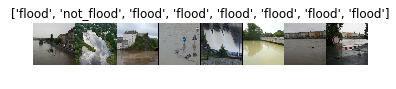

Prediction:


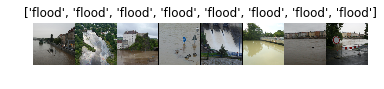

In [24]:
visualize_model(vgg16_trained)

In [16]:
len(loss_hist)

1

In [31]:
#??
#load pre-trained flooding weights from dataset
pkl_filename = "../features/VGG16_relu5_3.pickle"  
last_layer_weights = {} # pretrained_weights is an empty dict already

if os.path.getsize(pkl_filename) > 0:      
    with open(pkl_filename, "rb") as f:
        unpickler = pickle.Unpickler(f)
        # if file is not empty scores will be equal
        # to the value unpickled
        last_layer_weights = unpickler.load()
        
print (last_layer_weights['pollution_1'].shape)